# Colocalization between placental mQTL, psychiatric and developmental traits

Idea: for all heritable CpGs, test for colocalization between traits and GWAS summary statistics for conditions where a significant proportion of heritability can be explained by placental mQTL.
Traits to include:
* Neuropsychiatric
    1. OCD
    1. TS
    1. ADHD
    1. ASD
    1. MDD
    1. BIP
    1. AN
    1. SCZ
* Developmental: 
    1. Pubertal Growth Start
    1. Asthma
    1. Child BMI
    1. Child Onset Asthma

In [1]:
library(tidyverse)
library(data.table)
library(coloc)
library(bigsnpr)
library(here)
library(parallel)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.3     ✔ purrr   0.3.4
✔ tibble  3.1.0     ✔ dplyr   1.0.4
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘data.table’


The following objects are masked from ‘package:dplyr’:

    between, first, last


The following object is masked from ‘package:purrr’:

    transpose


This is a new update to coloc.

Loading required package: bigstatsr

here() starts at /scratch/st-dennisjk-1/wcasazza/sex_specific_mQTL



In [2]:
if (file.exists(here("data","marginal_mcpg_bonf.txt.gz"))){
    marginal_bonf <- fread(here("data","marginal_mcpg_bonf.txt.gz"),key="SNP")
}else{
    marginal <- fread(here("data","delahaye_richs_marginal_mecs_maf01.txt.gz"))
    marginal_bonf <- fread(here("data","delahaye_richs_marginal_bonf_maf05.txt.gz"))[Chr != 23]
    marginal_bonf <- marginal[Probe %in%marginal_bonf$Probe]
    fwrite(marginal_bonf,here("data","marginal_mcpg_bonf.txt.gz"),row.names=F,quote=F,sep='\t')
}

In [3]:
rds < -snp_readBed2(
    "/arc/project/st-dennisjk-1/shared/data/1000G_EUR_ldsc_data/1000G_EUR_Phase3_plink/1000G.EUR.QC.ALL.bed",
    backingfile=tempfile(),
)

In [ ]:
reference < -snp_attach(rds)

In [5]:
str(reference)

List of 3
 $ genotypes:Reference class 'FBM.code256' [package "bigstatsr"] with 16 fields
  ..$ extptr      :<externalptr> 
  ..$ extptr_rw   :<externalptr> 
  ..$ nrow        : int 489
  ..$ ncol        : int 9997231
  ..$ type        : Named int 1
  .. ..- attr(*, "names")= chr "unsigned char"
  ..$ backingfile : chr "/tmp/pbs.3124043.pbsha.ib.sockeye/Rtmp2tC1yx/file11da523a0fad.bk"
  ..$ is_read_only: logi FALSE
  ..$ address     :<externalptr> 
  ..$ address_rw  :<externalptr> 
  ..$ bk          : chr "/tmp/pbs.3124043.pbsha.ib.sockeye/Rtmp2tC1yx/file11da523a0fad.bk"
  ..$ rds         : chr "/tmp/pbs.3124043.pbsha.ib.sockeye/Rtmp2tC1yx/file11da523a0fad.rds"
  ..$ is_saved    : logi TRUE
  ..$ type_chr    : chr "unsigned char"
  ..$ type_size   : int 1
  ..$ file_size   : num 4.89e+09
  ..$ code256     : num [1:256] 0 1 2 NA NA NA NA NA NA NA ...
  ..and 26 methods, of which 12 are  possibly relevant:
  ..  add_columns, as.FBM, bm, bm.desc, check_dimensions,
  ..  check_write_permis

In [ ]:
compute_coloc <- function(SNP,mqtl,gwas,method="coloc", type="quant",s=NULL){# SNP must be in SNP column of mqtl and gwas
    D1 <- list(
            beta = mqtl$b,
            varbeta = mqtl$SE^2,
            snp = mqtl$SNP,
            position = mqtl$BP,
            N = 400,
            MAF = mqtl$Freq,
            type="quant"
        )
    D2 <- list(
            pvalues = pnorm(-abs(gwas$Z))*2,
            z=gwas$Z,
            snp = gwas$SNP,
            MAF = snp_MAF(reference$genotypes,ind.col = match(gwas$SNP,reference$map$marker.ID)),
            N = min(gwas$N),
            type=type,
            s = s
        )
    if(method == "susie"){
        LD <- snp_cor(reference$genotypes,ind.col = match(SNP, reference$map$marker.ID))^2
        LD <- as.matrix(LD)
        colnames(LD) <- SNP
        rownames(LD) <- SNP
        D1$LD <- LD
        D2$LD <- LD
        S1 <- runsusie(D1)
        S2 <- runsusie(D2)
        return(coloc.susie(S1,S2))
    }else if(method == "coloc"){
        return(coloc.abf(D1,D2))
    }else{
        return(NULL)
    }
}

In [14]:
gwas <- fread("../../tmp_GWAS/pgc_formatted_sumstats/adhd_jul2017.sumstats.gz",key="SNP")

tmp_marginal_bonf <- marginal_bonf[intersect(gwas$SNP,reference$map$marker.ID),on="SNP",nomatch=0]

eligible_cpg <- unlist(mclapply(
    unique(tmp_marginal_bonf$Probe),
    function(probe){
        mqtl <- tmp_marginal_bonf[Probe == probe]
        gwas_tmp <- gwas[mqtl$SNP,on="SNP"]
        return(min(mqtl$p) < 5e-8 & max(abs(gwas_tmp$Z)) > 5.45 )
    },
    mc.cores=16
))
test <- mclapply(
    unique(marginal_bonf$Probe)[eligible_cpg],
    function(probe){
        mqtl <- tmp_marginal_bonf[Probe == probe]
        gwas_tmp <- gwas[SNP %in% mqtl$SNP]
        res <- suppressMessages(compute_coloc(mqtl$SNP,mqtl,gwas_tmp,method="coloc",s=0.36,type="cc")$summary)
        return(res)
    },
    mc.cores=16
)

names(test) <- unique(marginal_bonf$Probe)[eligible_cpg]
result_adhd <- rbindlist(lapply(test,function(x)data.table(t(x))))
result_adhd

# Repeating above for all psychiatric GWAS

In [69]:
sumstat_files < -c(
    "/scratch/st-dennisjk-1/wcasazza/tmp_GWAS/pgc_formatted_sumstats/adhd_jul2017.sumstats.gz",
    "/scratch/st-dennisjk-1/wcasazza/tmp_GWAS/pgc_formatted_sumstats/anxiety.meta.full.fs.tbl.sumstats.gz",
    "/scratch/st-dennisjk-1/wcasazza/tmp_GWAS/pgc_formatted_sumstats/anxiety.meta.full.cc.tbl.sumstats.gz",
    "/scratch/st-dennisjk-1/wcasazza/tmp_GWAS/pgc_formatted_sumstats/pgcAN2.2019-07_refmt.vcf.tsv.sumstats.gz",
    "/scratch/st-dennisjk-1/wcasazza/tmp_GWAS/pgc_formatted_sumstats/AUDIT_UKB_2018_AJP_fixed.txt.sumstats.gz",
    "/scratch/st-dennisjk-1/wcasazza/tmp_GWAS/pgc_formatted_sumstats/Cannabis_ICC_23andmetop_UKB_het_fixed.txt.sumstats.gz",
    "/scratch/st-dennisjk-1/wcasazza/tmp_GWAS/pgc_formatted_sumstats/iPSYCH-PGC_ASD_Nov2017.sumstats.gz",
    "/scratch/st-dennisjk-1/wcasazza/tmp_GWAS/pgc_formatted_sumstats/ocd_aug2017.sumstats.gz",
    "/scratch/st-dennisjk-1/wcasazza/tmp_GWAS/pgc_formatted_sumstats/pgc_alcdep.eur_unrelated.aug2018_release_refmt.txt.sumstats.gz",
    "/scratch/st-dennisjk-1/wcasazza/tmp_GWAS/pgc_formatted_sumstats/pgc_bip_2018.sumstats.gz",
    "/scratch/st-dennisjk-1/wcasazza/tmp_GWAS/pgc_formatted_sumstats/PGC_UKB_depression_genome-wide_fixed.txt.sumstats.gz",
    "/scratch/st-dennisjk-1/wcasazza/tmp_GWAS/pgc_formatted_sumstats/MDD2018_ex23andMe.sumstats.gz",
    "/scratch/st-dennisjk-1/wcasazza/tmp_GWAS/pgc_formatted_sumstats/PGC3_SCZ_wave3_public.v2.tsv.sumstats.gz",
    "/scratch/st-dennisjk-1/wcasazza/tmp_GWAS/pgc_formatted_sumstats/tag.cpd.tbl.sumstats.gz",
    "/scratch/st-dennisjk-1/wcasazza/tmp_GWAS/pgc_formatted_sumstats/TS_Oct2018.sumstats.gz",
    "/scratch/st-dennisjk-1/wcasazza/tmp_GWAS/pgc_formatted_sumstats/pts_all_freeze2_overall.results.sumstats.gz",
)
trait_names < -c(
    "ADHD",
    "ANXFS",
    "ANX",
    "AN",
    "AUDIT",
    "CUD",
    "ASD",
    "OCD",
    "ALC",
    "BIP",
    "MDD",
    "MDD2018",
    "SCZ",
    "TAG_CPD",
    "TS",
    "PTSD",
)
sample_prev < -c(
    0.36,
    NULL,
    0.33,
    0.23,
    NULL,
    0.30,
    0.40,
    0.28,
    0.26,
    0.15,
    0.34,
    0.35,
    0.42,
    NULL,
    0.34,
    0.15,
)

In [ ]:
result <- list()
for( i in 1:length(sumstat_files)){
    gwas <- fread(sumstat_files[i])
    tmp_marginal_bonf <- marginal_bonf[intersect(gwas$SNP,reference$map$marker.ID),on="SNP",nomatch=0]
    eligible_cpg <- unlist(mclapply(
        unique(tmp_marginal_bonf$Probe),
        function(probe){
            mqtl <- tmp_marginal_bonf[Probe == probe]
            gwas_tmp <- gwas[mqtl$SNP,on="SNP"]
            return(min(mqtl$p) < 5e-8 & max(abs(gwas_tmp$Z)) > 5.45 )
        },
        mc.cores=16
    ))
    if(sum(eligible_cpg) ){
        test <- mclapply(
            unique(tmp_marginal_bonf$Probe)[eligible_cpg],
            function(probe){
                mqtl <- tmp_marginal_bonf[Probe == probe]
                gwas_tmp <- gwas[SNP %in% mqtl$SNP]
                res <- suppressMessages(
                    compute_coloc(
                        mqtl$SNP,
                        mqtl,
                        gwas_tmp,
                        method="coloc",
                        s=sample_prev[i],
                        type=ifelse(is.null(sample_prev[i]),"quant","cc")
                    )$summary
                )
                return(res)
            },
            mc.cores=16
        )
        names(test) <- unique(tmp_marginal_bonf$Probe)[eligible_cpg]
        res <- rbindlist(lapply(test,function(x)data.table(t(x))))
        result[[trait_names[i]]] <- res
    }
}

In [64]:
str(result)

 list()


# Neonatal Traits

In [ ]:
sumstat_files < -c(
    "/scratch/st-dennisjk-1/wcasazza/tmp_GWAS/neonatal_gwas/formatted/Pubertal_growth_PGF_PGM_combined.txt.sumstats.gz",
    "/scratch/st-dennisjk-1/wcasazza/tmp_GWAS/neonatal_gwas/formatted/EGG_Obesity_Meta_Analysis_1.txt.sumstats.gz",
    "/scratch/st-dennisjk-1/wcasazza/tmp_GWAS/neonatal_gwas/formatted/age_hay_fever_irnt.gwas.imputed_v3.both_sexes.tsv.sumstats.gz",
    "/scratch/st-dennisjk-1/wcasazza/tmp_GWAS/neonatal_gwas/formatted/EGG-TotalGWG-Offspring.txt.sumstats.gz",
    "/scratch/st-dennisjk-1/wcasazza/tmp_GWAS/neonatal_gwas/formatted/Pubertal_growth_PTF_PTM_combined.txt.sumstats.gz",
    "/scratch/st-dennisjk-1/wcasazza/tmp_GWAS/neonatal_gwas/formatted/age_hay_fever_raw.gwas.imputed_v3.both_sexes.tsv.sumstats.gz",
    "/scratch/st-dennisjk-1/wcasazza/tmp_GWAS/neonatal_gwas/formatted/age_asthma_raw.gwas.imputed_v3.both_sexes.tsv.sumstats.gz",
    "/scratch/st-dennisjk-1/wcasazza/tmp_GWAS/neonatal_gwas/formatted/age_asthma_irnt.gwas.imputed_v3.both_sexes.tsv.sumstats.gz",
    "/scratch/st-dennisjk-1/wcasazza/tmp_GWAS/neonatal_gwas/formatted/age_diabetes_raw.gwas.imputed_v3.both_sexes.tsv.sumstats.gz",
    "/scratch/st-dennisjk-1/wcasazza/tmp_GWAS/neonatal_gwas/formatted/age_diabetes_irnt.gwas.imputed_v3.both_sexes.tsv.sumstats.gz",
    "/scratch/st-dennisjk-1/wcasazza/tmp_GWAS/neonatal_gwas/formatted/EGG_BMI_HapMap_DISCOVERY.txt.sumstats.gz",
    "/scratch/st-dennisjk-1/wcasazza/tmp_GWAS/neonatal_gwas/formatted/Pubertal_growth_10F_12M_combined.txt.sumstats.gz",
    "/scratch/st-dennisjk-1/wcasazza/tmp_GWAS/neonatal_gwas/formatted/EGG_HC_DISCOVERY.v2.txt.sumstats.gz",
    "/scratch/st-dennisjk-1/wcasazza/tmp_GWAS/neonatal_gwas/formatted/CHILD_ONSET_ASTHMA.20180501.allchr.assoc.GC.sumstats.gz",
)
trait_names < -c(
    "ADHD",
    "ANXFS",
    "ANX",
    "AN",
    "AUDIT",
    "CUD",
    "ASD",
    "OCD",
    "ALC",
    "BIP",
    "MDD",
    "MDD2018",
    "SCZ",
    "TAG_CPD",
    "TS",
    "PTSD",
)
sample_prev < -c(
    NULL, NULL, NULL, NULL, NULL, NULL, NULL, NULL, NULL, NULL, NULL, NULL, NULL, 0.0296
)

## Summary of all trait colocalization

In [11]:
trait_coloc <- dir(here("data"),pattern= ".*colocalization.txt",full.names = TRUE)
all_coloc <- lapply(trait_coloc,fread)
names(all_coloc) <- gsub(".*/(.*)_colocalization.txt","\\1",trait_coloc)
coloc_table <- rbindlist(all_coloc,idcol="GWAS")

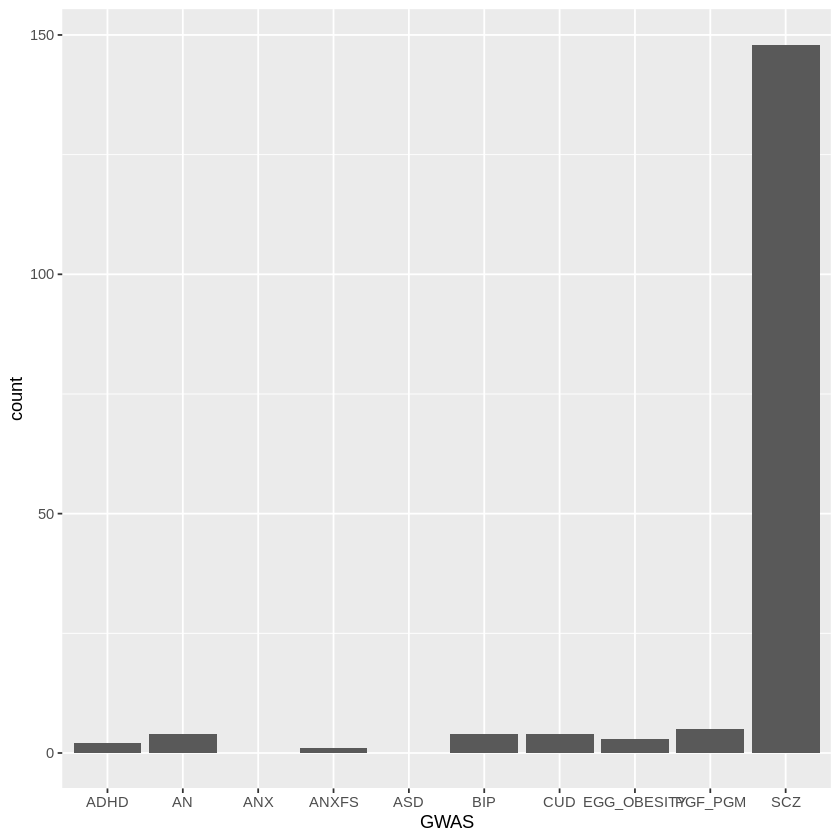

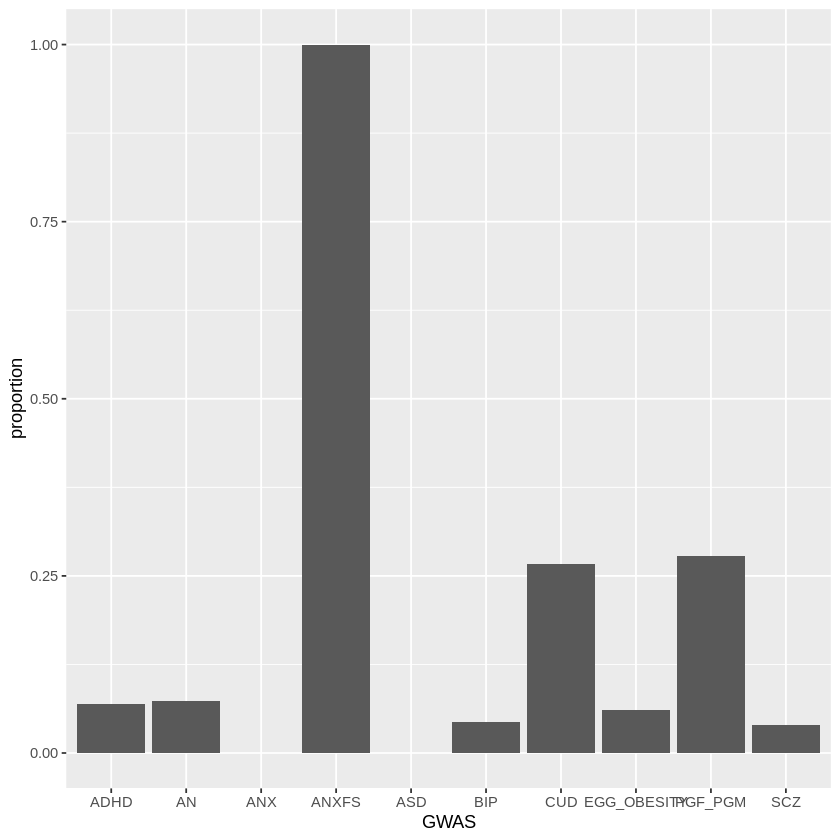

In [28]:
ggplot(coloc_table[,.(proportion = sum(PP.H4.abf > 0.95) / .N,count=sum(PP.H4.abf >0.95)),by=GWAS], aes(GWAS,count)) + geom_col()
ggplot(coloc_table[,.(proportion = sum(PP.H4.abf > 0.95) / .N,count=sum(PP.H4.abf >0.95)),by=GWAS], aes(GWAS,proportion)) + geom_col()

In [20]:
manifest < -fread("../../450k_annotation.csv")

GWAS,probe,nsnps,PP.H0.abf,PP.H1.abf,PP.H2.abf,PP.H3.abf,PP.H4.abf
<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
SCZ,cg08213375,71,2.797185e-40,1.808582e-11,3.106742e-32,0.0010097427,0.9989903
SCZ,cg20656587,160,1.880769e-17,2.491149e-05,3.461962e-14,0.0448999059,0.9550752
SCZ,cg22687902,40,4.101200e-23,1.590592e-05,9.560575e-20,0.0361154701,0.9638686
SCZ,cg12609785,48,7.446882e-22,1.701924e-05,2.031117e-18,0.0454650111,0.9545180
SCZ,cg17117718,51,2.915500e-77,1.533934e-05,8.390400e-74,0.0431876624,0.9567970
SCZ,cg22968622,51,9.987838e-53,1.748718e-05,2.874359e-49,0.0493750199,0.9506075
SCZ,cg01570182,11,4.162536e-09,1.954115e-05,2.350610e-06,0.0100450738,0.9899330
SCZ,cg00593414,11,5.400249e-08,2.007548e-05,3.049554e-05,0.0103471430,0.9896022
SCZ,cg08670715,11,1.094840e-45,2.092950e-05,6.182628e-43,0.0108298670,0.9891492


In [21]:
SCZ_annotated <- merge(coloc_table[GWAS == "SCZ" & PP.H4.abf > 0.95],manifest, by.x="probe",by.y="Name")

In [22]:
SCZ_annotated

probe,GWAS,nsnps,PP.H0.abf,PP.H1.abf,PP.H2.abf,PP.H3.abf,PP.H4.abf,V1,chr,⋯,UCSC_RefGene_Name,UCSC_RefGene_Accession,UCSC_RefGene_Group,Phantom,DMR,Enhancer,HMM_Island,Regulatory_Feature_Name,Regulatory_Feature_Group,DHS
<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<lgl>,<chr>,<chr>,<chr>,<lgl>
cg00593414,SCZ,11,5.400249e-08,2.007548e-05,3.049554e-05,1.034714e-02,0.9896022,cg00593414,chr17,⋯,,,,,,NA,,,,NA
cg00758881,SCZ,200,3.296017e-09,6.257570e-05,8.602668e-07,1.534779e-02,0.9845888,cg00758881,chr16,⋯,NDRG4;NDRG4;NDRG4,NM_020465;NM_022910;NM_001130487,Body;Body;Body,,,NA,16:57092141-57092234,16:58534335-58535730,Unclassified_Cell_type_specific,TRUE
cg00785042,SCZ,201,1.438456e-06,7.887926e-05,4.049871e-04,2.122961e-02,0.9782851,cg00785042,chr16,⋯,NDRG4;NDRG4;NDRG4,NM_020465;NM_022910;NM_001130487,Body;Body;Body,,,NA,,,,NA
cg01026383,SCZ,625,1.249675e-34,6.769004e-18,4.188319e-19,2.170820e-02,0.9782918,cg01026383,chr6,⋯,HLA-DMB,NM_002118,Body,,,NA,,,,NA
cg01097406,SCZ,202,1.375158e-10,7.206703e-04,3.818281e-09,1.902997e-02,0.9802494,cg01097406,chr16,⋯,,,,,,NA,16:88202602-88202650,,,NA
cg01343363,SCZ,200,1.381931e-06,7.019645e-05,3.606868e-04,1.733918e-02,0.9822286,cg01343363,chr16,⋯,NDRG4;NDRG4;NDRG4,NM_020465;NM_022910;NM_001130487,Body;Body;Body,,,NA,,16:58533552-58534234,Unclassified,TRUE
cg01374870,SCZ,624,1.099375e-44,6.775798e-18,3.684583e-29,2.173099e-02,0.9782690,cg01374870,chr6,⋯,HLA-DMB,NM_002118,Body,,,NA,,,,NA
cg01570182,SCZ,11,4.162536e-09,1.954115e-05,2.350610e-06,1.004507e-02,0.9899330,cg01570182,chr17,⋯,,,,,,NA,17:41693218-41693703,,,NA
cg01617117,SCZ,332,3.867669e-13,1.169510e-05,6.181613e-10,1.770975e-02,0.9822786,cg01617117,chr2,⋯,EIF2AK2;EIF2AK2,NM_001135651;NM_002759,TSS200;TSS200,,,NA,2:37237321-37237886,2:37383067-37384938,Promoter_Associated,NA
